In [22]:
import numpy as np
import pandas as pd

import os
import random

import warnings

warnings.filterwarnings(action='ignore')

path = '/opt/ml/input/data/'
dat = pd.read_csv(path + 'FE/FE_total.csv')
dat['last_answerCode'] = dat.groupby("userID")['answerCode'].shift(1).fillna(1)

In [23]:
_train = dat[dat['answerCode'] >= 0]
_test = dat[dat['answerCode'] < 0]

In [24]:
# 유저 마다 가장 마지막 문제를 맞추는 것을 기준으로 평가 하려함
# test 유저에 경우 가장 마지막 문제 전 문제를 맞추는 것을 기준으로 평가함.
user_final_time = _train.groupby('userID')['Timestamp'].max()
_train['train_valid'] = _train.apply(lambda x : -1 if x.Timestamp == user_final_time[x.userID] else x['answerCode'], axis = 1)
_valid = _train[_train['train_valid'] < 0]
_train = _train[_train['train_valid'] >= 0]

In [25]:
# 모델에 적용하기 전 기본적인 데이터 전처리 부분
## 라벨링, 필요없는 칼럼 제거
_train_value = _train['answerCode']
_train.drop(['Timestamp', 'testId', 'train_valid', 'answerCode','category_st_qcut_5'], axis = 1, inplace = True)

_valid_value = _valid['answerCode']
_valid.drop(['Timestamp', 'testId', 'train_valid', 'answerCode','category_st_qcut_5'], axis = 1, inplace = True)

_test.drop(['Timestamp', 'testId', 'answerCode','category_st_qcut_5'], axis = 1, inplace = True)

In [26]:
# CatBoost에 적용하기 위해선 문자열 데이터로 변환 필요.
_train['userID'] = _train['userID'].astype('str')
_train['KnowledgeTag'] = _train['KnowledgeTag'].astype('str')
_train['last_answerCode'] = _train['last_answerCode'].astype('str')

_valid['userID'] = _valid['userID'].astype('str')
_valid['KnowledgeTag'] = _valid['KnowledgeTag'].astype('str')
_valid['last_answerCode'] = _valid['last_answerCode'].astype('str')

_test['userID'] = _test['userID'].astype('str')
_test['KnowledgeTag'] = _test['KnowledgeTag'].astype('str')
_test['last_answerCode'] = _test['last_answerCode'].astype('str')

In [27]:
#!pip install catboost
# 가상환경에 패키지 설치 필요할듯
from catboost import CatBoostClassifier

# 하이퍼파라미터 수정할 여지가 많으니 추가나 수정하고 싶은 사람 수정해도 괜찮을듯.
# 일단 지난번에 사용했던 파라미터들 주석으로 들고 옴. 참고하면서 공부하면 좋을듯.

# params_cat = {
#     "task_type" : "GPU",
#     "devices" : '0',
#     "random_state": SEED,
#     'learning_rate': 0.04574578205475402, 
#     'bagging_temperature': 0.12172958098369972, 
#     'n_estimators': 2000, 
#     'max_depth': 8, 
#     'random_strength': 28, 
#     'l2_leaf_reg': 1.6285455533915874e-05, 
#     'min_child_samples': 18, 
#     'max_bin': 441, 
#     'od_type': 'Iter',
#     "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
# }

# model = CatBoostRegressor(**params_cat)

# 실제 적용한 모델은 learning_rate, iterations(=n_estimators, 아마도?)만 사용함.
cat_model = CatBoostClassifier(learning_rate=0.05, iterations=1000, task_type="GPU")
cat_model.fit(_train, _train_value, early_stopping_rounds=100, cat_features=list(_train.columns) ,verbose=500)


0:	learn: 0.6715069	total: 109ms	remaining: 1m 49s
500:	learn: 0.4347583	total: 45.3s	remaining: 45.1s
999:	learn: 0.4160625	total: 1m 29s	remaining: 0us


In [28]:
_train[['last_answerCode']][-5:]

,last_answerCode
2526694,1.0
2526695,0.0
2526696,0.0
2526697,1.0
2526698,1.0


In [29]:
_train_value[-5:]

2526694    0
2526695    0
2526696    1
2526697    1
2526698    1
Name: answerCode, dtype: int64

In [30]:
# valid score를 확인해봄.
# 모델 환경상 test score보다 떨어질 수도. (토론 필요)
# 실제 제출한 test score은 auc는 0.7864, acc는 0.7124
from sklearn.metrics import accuracy_score, roc_auc_score

_valid_pred = cat_model.predict_proba(_valid)[:,1]
print(roc_auc_score(_valid_value, _valid_pred)) # auc
print(accuracy_score(_valid_value, np.where(_valid_pred >= 0.5, 1, 0))) # acc, 정확도

0.8340694372560813
0.7586252478519497


Text(0.5, 1.0, 'Feature Importance')

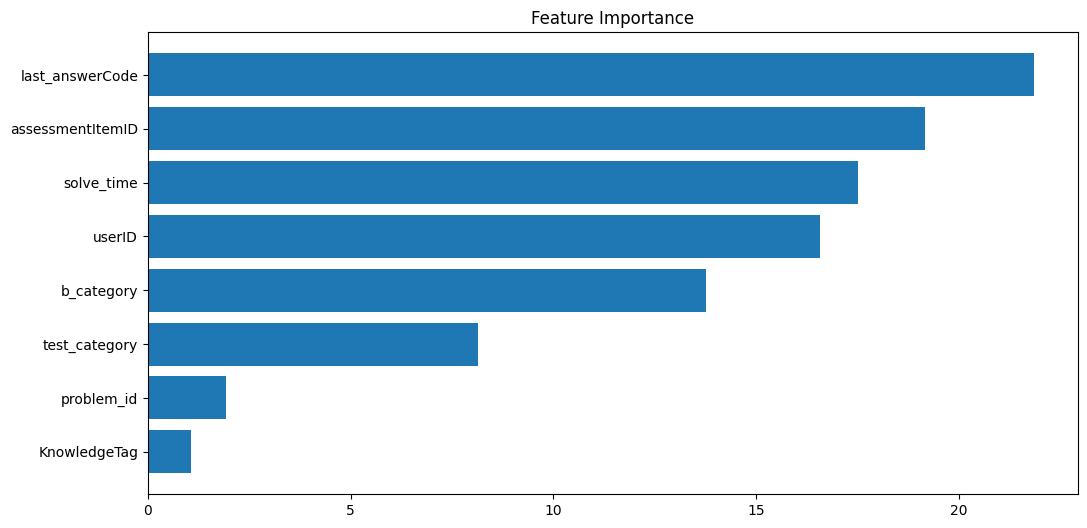

In [31]:
import matplotlib.pyplot as plt

feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(_valid.columns)[sorted_idx])
plt.title("Feature Importance")

In [32]:
# submission 제출하기 위한 코드

_test_pred = cat_model.predict_proba(_test)[:,1]
_test['prediction'] = _test_pred
submission = _test['prediction'].reset_index(drop = True).reset_index()
submission.rename(columns = {'index':'id'}, inplace = True)
submission.to_csv('./output/last_code_submission2.csv', index = False)